<a href="https://colab.research.google.com/github/Renass/Yasuo_project/blob/transfer_res_net/classification/classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import files
import torchvision
import glob
from torchvision import transforms
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib
from matplotlib import pyplot as plt
import zipfile
from tqdm import tqdm
from PIL import Image
import cv2
import random

#Data preproceccing

In [2]:
from google.colab import drive
drive.mount('/content/drive')


zip_path = '/content/drive/MyDrive/Colab_Notebooks/datasets/stm-data/stm-data.zip'
z = zipfile.ZipFile(zip_path, 'r')
z.extractall()
print(os.listdir())


path = '/content/stm-data/JointDataset'
train_bad_dir = path + '/Train/bad'
train_good_dir = path + '/Train/good'
test_bad_dir = path + '/Test/bad'
test_good_dir = path + '/Test/good'

train_bad_names = glob.glob(train_bad_dir + '/*.npy')
train_good_names = glob.glob(train_good_dir + '/*.npy')
test_bad_names = glob.glob(test_bad_dir + '/*.npy')
test_good_names = glob.glob(test_good_dir + '/*.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.config', 'drive', 'stm-data', 'sample_data']


#Preparing batches

In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, names, y, transform = None):
        self.names = names
        self.y = y
        if transform is None:
            self.should_transform = False
        else:
            self.transform = transform
            self.should_transform = True

    def __len__(self):
        return len(self.names)

    def __getitem__(self,idx):
        self.mas = np.load(self.names[idx])
        self.mas = torch.from_numpy(self.mas)
        self.mas = 255*(self.mas - self.mas.min())/(self.mas.max()-self.mas.min())
        self.img =self.mas.numpy()
        self.img = cv2.cvtColor(self.img.astype(np.uint8), cv2.COLOR_GRAY2RGB)

        if self.should_transform:
            self.img_transformed = self.transform(self.img)
        else:
            self.img_transformed = self.img
        return self.img_transformed, self.y

In [4]:
transform = torchvision.transforms.Compose([   
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),              
    transforms.ToTensor(),                  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                    
])


#bad: y=0
#good: y=1
train_bad_dataset = MyDataset(names=train_bad_names, y=0, transform=transform)
train_good_dataset = MyDataset(names=train_good_names, y=1, transform=transform)
train_dataset = train_bad_dataset + train_good_dataset

test_bad_dataset = MyDataset(names=test_bad_names, y=0, transform=transform)
test_good_dataset = MyDataset(names=test_good_names, y=1, transform=transform)
test_dataset = test_bad_dataset + test_good_dataset


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
#torch.Size([batch_size,channels,64,64])

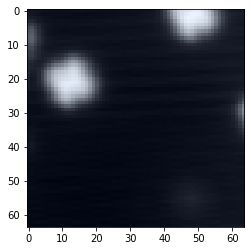

1





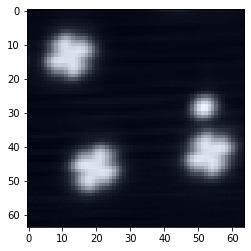

1





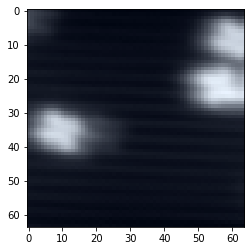

0





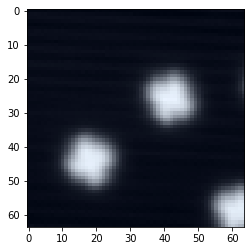

0





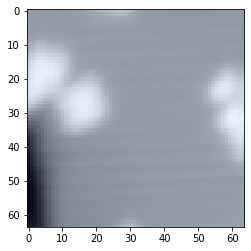

0





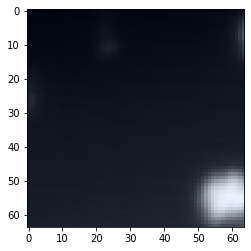

0





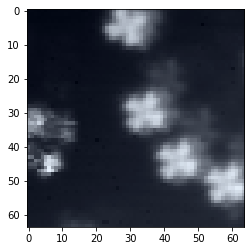

0





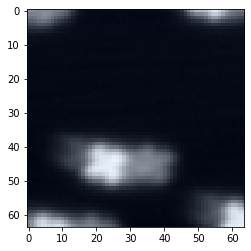

0





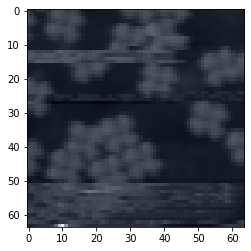

0





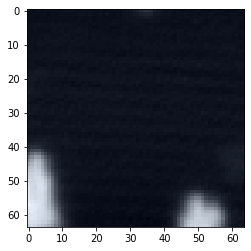

0





In [5]:
def watch_pics(dataset, n=10):
    l = len(dataset)
    for i in range(n):
        r = random.randint(0,l-1)
        data = dataset[r][0]
        data = (data - data.min())/(data.max()-data.min())
        label = dataset[r][1]
        data = data.permute(1,2,0)
        plt.imshow(data)
        plt.show()
        print(str(label)+"\n\n\n")
    return 


watch_pics(train_dataset)

#Train-Test procedures

In [6]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            true_negative = 0
            true_positive = 0
            false_negative = 0
            false_positive = 0
            all = 0 
            if phase == 'train':
                dataloader = train_loader
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = test_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    for i, single_pred in enumerate(preds_class):
                        if single_pred< 0.5:
                            if labels[i]<0.5:
                                true_negative += 1
                                
                            else:
                                false_negative += 1
                                
                        else:
                            if labels[i]<0.5:
                                false_positive += 1
                                
                            else:
                                true_positive += 1
                                

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            scheduler.step()
            
            precision0 = true_negative / (true_negative + false_negative)
            precision1 = true_positive / (true_positive + false_positive)
            recall0 = true_negative / (true_negative + false_positive)
            recall1 = true_positive / (true_positive + false_negative)
            print(' {} Loss: {:.4f} Acc: {:.4f} \n recall0: {:.4f}    recall1: {:.4f} \n precision0: {:.4f}    precision1: {:.4f} \n\n'.format(phase, epoch_loss, epoch_acc, recall0, recall1, precision0, precision1), flush=True)

    return model

In [7]:
#old version


def my_ln(x):
  return torch.log(x+10e-45)

def binary_cross_entropy_weighted(pred, target):
    return torch.mean(-2*target*my_ln(pred)-(1-target)*my_ln(1-pred))





def train(model, train_loader, epochs, optimizer):
    model.train()
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for data,target in train_loader:
            data=data.to(device)
            target=target.to(device)
            target = target.unsqueeze(1)
            optimizer.zero_grad()   # zero the gradient buffers
            output = model.forward(data)
            output = output.double()


            #loss = binary_cross_entropy_weighted(output, target)
            
            loss.backward()
            loss_samples.append(loss.data.cpu().numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

In [8]:
#old version




def test(model, device, test_loader):
    model.eval()
    loss=0
    accuracy = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:

            
            data, target = data.to(device), target.to(device)
            output = model.forward(data)
            output = output.double()
            target = target.unsqueeze(1)

            loss+= F.cross_entropy(output,target)
            #loss+= binary_cross_entropy_weighted(output, target)
            pred = target.clone()
            for i,x in enumerate(output):
                ans = 0.
                if x > 0.5:
                    ans = 1.
                pred[i] = ans 


            for i,single_pred in enumerate(pred):
                if single_pred == target[i]:
                    correct+= 1
            total += len(pred)
    loss = loss/len(test_loader)
    accuracy = correct / total
    
    print('Loss: ',loss.data.item())
    print('\n Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, total, 100. * accuracy))

#Main loop

In [9]:
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)



model = torchvision.models.resnet34(pretrained = True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2).to(device)



weight = torch.tensor([1.,4.]).to(device)
loss = torch.nn.CrossEntropyLoss(weight = weight)
lr = 10e-3
optimizer=optim.Adam(model.parameters(), lr=lr, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

cuda


In [10]:
train_model(model, loss, optimizer, scheduler, num_epochs=20)

Epoch 0/19:


100%|██████████| 1131/1131 [00:20<00:00, 53.87it/s]

 train Loss: 1.5317 Acc: 0.6501 
 recall0: 0.6554    recall1: 0.6333 
 precision0: 0.8565    precision1: 0.3549 





100%|██████████| 388/388 [00:06<00:00, 60.09it/s]

 val Loss: 3.1077 Acc: 0.4224 
 recall0: 0.2574    recall1: 0.9532 
 precision0: 0.9465    precision1: 0.2850 


Epoch 1/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.44it/s]

 train Loss: 1.6040 Acc: 0.6516 
 recall0: 0.6572    recall1: 0.6333 
 precision0: 0.8569    precision1: 0.3561 





100%|██████████| 388/388 [00:06<00:00, 60.63it/s]

 val Loss: 2.2047 Acc: 0.5202 
 recall0: 0.4114    recall1: 0.8693 
 precision0: 0.9102    precision1: 0.3144 


Epoch 2/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.59it/s]

 train Loss: 1.6004 Acc: 0.6597 
 recall0: 0.6660    recall1: 0.6390 
 precision0: 0.8604    precision1: 0.3641 





100%|██████████| 388/388 [00:06<00:00, 60.96it/s]

 val Loss: 1.6908 Acc: 0.7394 
 recall0: 0.8275    recall1: 0.4575 
 precision0: 0.8308    precision1: 0.4516 


Epoch 3/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.38it/s]

 train Loss: 1.5247 Acc: 0.6629 
 recall0: 0.6661    recall1: 0.6521 
 precision0: 0.8648    precision1: 0.3689 





100%|██████████| 388/388 [00:06<00:00, 59.17it/s]

 val Loss: 2.0231 Acc: 0.7515 
 recall0: 0.8576    recall1: 0.4085 
 precision0: 0.8236    precision1: 0.4711 


Epoch 4/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.27it/s]

 train Loss: 1.5750 Acc: 0.6629 
 recall0: 0.6691    recall1: 0.6413 
 precision0: 0.8617    precision1: 0.3671 





100%|██████████| 388/388 [00:06<00:00, 60.86it/s]

 val Loss: 1.6704 Acc: 0.7207 
 recall0: 0.7686    recall1: 0.5664 
 precision0: 0.8509    precision1: 0.4319 


Epoch 5/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.26it/s]

 train Loss: 1.0304 Acc: 0.6936 
 recall0: 0.6987    recall1: 0.6770 
 precision0: 0.8785    precision1: 0.4021 





100%|██████████| 388/388 [00:06<00:00, 60.27it/s]

 val Loss: 0.8514 Acc: 0.6635 
 recall0: 0.6316    recall1: 0.7658 
 precision0: 0.8967    precision1: 0.3923 


Epoch 6/19:



100%|██████████| 1131/1131 [00:20<00:00, 54.58it/s]

 train Loss: 0.7184 Acc: 0.7060 
 recall0: 0.7114    recall1: 0.6878 
 precision0: 0.8839    precision1: 0.4163 





100%|██████████| 388/388 [00:06<00:00, 59.82it/s]

 val Loss: 0.7926 Acc: 0.6249 
 recall0: 0.5585    recall1: 0.8377 
 precision0: 0.9172    precision1: 0.3708 


Epoch 7/19:



100%|██████████| 1131/1131 [00:20<00:00, 54.23it/s]

 train Loss: 0.6571 Acc: 0.7050 
 recall0: 0.7062    recall1: 0.7001 
 precision0: 0.8872    precision1: 0.4163 





100%|██████████| 388/388 [00:06<00:00, 59.42it/s]

 val Loss: 0.6041 Acc: 0.7103 
 recall0: 0.7006    recall1: 0.7429 
 precision0: 0.8977    precision1: 0.4352 


Epoch 8/19:



100%|██████████| 1131/1131 [00:20<00:00, 54.52it/s]

 train Loss: 0.6144 Acc: 0.7101 
 recall0: 0.7106    recall1: 0.7089 
 precision0: 0.8908    precision1: 0.4230 





100%|██████████| 388/388 [00:06<00:00, 59.64it/s]

 val Loss: 0.5764 Acc: 0.7256 
 recall0: 0.7253    recall1: 0.7266 
 precision0: 0.8952    precision1: 0.4510 


Epoch 9/19:



100%|██████████| 1131/1131 [00:20<00:00, 54.86it/s]

 train Loss: 0.6083 Acc: 0.7060 
 recall0: 0.7083    recall1: 0.6989 
 precision0: 0.8871    precision1: 0.4176 





100%|██████████| 388/388 [00:06<00:00, 59.92it/s]

 val Loss: 0.5740 Acc: 0.7173 
 recall0: 0.7135    recall1: 0.7342 
 precision0: 0.8963    precision1: 0.4431 


Epoch 10/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.30it/s]

 train Loss: 0.5666 Acc: 0.7254 
 recall0: 0.7294    recall1: 0.7120 
 precision0: 0.8943    precision1: 0.4406 





100%|██████████| 388/388 [00:06<00:00, 60.51it/s]

 val Loss: 0.5696 Acc: 0.7265 
 recall0: 0.7314    recall1: 0.7092 
 precision0: 0.8901    precision1: 0.4505 


Epoch 11/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.07it/s]

 train Loss: 0.5503 Acc: 0.7229 
 recall0: 0.7236    recall1: 0.7204 
 precision0: 0.8963    precision1: 0.4382 





100%|██████████| 388/388 [00:06<00:00, 60.03it/s]

 val Loss: 0.5804 Acc: 0.7102 
 recall0: 0.6949    recall1: 0.7593 
 precision0: 0.9029    precision1: 0.4359 


Epoch 12/19:



100%|██████████| 1131/1131 [00:20<00:00, 54.64it/s]

 train Loss: 0.5560 Acc: 0.7269 
 recall0: 0.7303    recall1: 0.7158 
 precision0: 0.8957    precision1: 0.4428 





100%|██████████| 388/388 [00:06<00:00, 59.84it/s]

 val Loss: 0.5424 Acc: 0.7015 
 recall0: 0.6661    recall1: 0.8137 
 precision0: 0.9201    precision1: 0.4308 


Epoch 13/19:



100%|██████████| 1131/1131 [00:20<00:00, 54.87it/s]

 train Loss: 0.5442 Acc: 0.7252 
 recall0: 0.7216    recall1: 0.7385 
 precision0: 0.9021    precision1: 0.4426 





100%|██████████| 388/388 [00:06<00:00, 60.42it/s]

 val Loss: 0.5607 Acc: 0.7254 
 recall0: 0.7283    recall1: 0.7157 
 precision0: 0.8919    precision1: 0.4500 


Epoch 14/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.46it/s]

 train Loss: 0.5459 Acc: 0.7211 
 recall0: 0.7233    recall1: 0.7131 
 precision0: 0.8939    precision1: 0.4355 





100%|██████████| 388/388 [00:06<00:00, 59.22it/s]

 val Loss: 0.5553 Acc: 0.7130 
 recall0: 0.7009    recall1: 0.7516 
 precision0: 0.9009    precision1: 0.4384 


Epoch 15/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.23it/s]

 train Loss: 0.5418 Acc: 0.7259 
 recall0: 0.7238    recall1: 0.7327 
 precision0: 0.9005    precision1: 0.4426 





100%|██████████| 388/388 [00:06<00:00, 59.74it/s]

 val Loss: 0.5492 Acc: 0.6977 
 recall0: 0.6675    recall1: 0.7963 
 precision0: 0.9134    precision1: 0.4265 


Epoch 16/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.09it/s]

 train Loss: 0.5411 Acc: 0.7203 
 recall0: 0.7186    recall1: 0.7258 
 precision0: 0.8975    precision1: 0.4357 





100%|██████████| 388/388 [00:06<00:00, 60.37it/s]

 val Loss: 0.5783 Acc: 0.6643 
 recall0: 0.6069    recall1: 0.8486 
 precision0: 0.9281    precision1: 0.4013 


Epoch 17/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.43it/s]

 train Loss: 0.5353 Acc: 0.7312 
 recall0: 0.7320    recall1: 0.7285 
 precision0: 0.9001    precision1: 0.4486 





100%|██████████| 388/388 [00:06<00:00, 60.84it/s]

 val Loss: 0.5362 Acc: 0.7131 
 recall0: 0.6881    recall1: 0.7919 
 precision0: 0.9142    precision1: 0.4409 


Epoch 18/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.08it/s]

 train Loss: 0.5401 Acc: 0.7252 
 recall0: 0.7240    recall1: 0.7285 
 precision0: 0.8991    precision1: 0.4414 





100%|██████████| 388/388 [00:06<00:00, 59.93it/s]

 val Loss: 0.5358 Acc: 0.7028 
 recall0: 0.6813    recall1: 0.7734 
 precision0: 0.9064    precision1: 0.4298 


Epoch 19/19:



100%|██████████| 1131/1131 [00:20<00:00, 55.07it/s]

 train Loss: 0.5400 Acc: 0.7257 
 recall0: 0.7230    recall1: 0.7346 
 precision0: 0.9010    precision1: 0.4425 





100%|██████████| 388/388 [00:06<00:00, 59.87it/s]

 val Loss: 0.5299 Acc: 0.7339 
 recall0: 0.7344    recall1: 0.7353 
 precision0: 0.8993    precision1: 0.4623 




ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  